###Libraries**

In [2]:
pip install segmentation_models_pytorch 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=976da02eca1e18e8aa8682e27b6e94914aed019fc7d57a4c154e0a45442527b5
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=cf286cb9ccfe7f35217d70716b4df112c2b92ead4f213a630907445d73bdea01
  Stored in directory: /root/.cache/pip/w

In [3]:
pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
import torch
print(torch.__version__)



1.13.1+cu116


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Defining train / val / test directories 📁


In [6]:
DATA_DIR = '/content/drive/MyDrive/project'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [7]:
class_dict = pd.read_csv("/content/drive/MyDrive/project/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [8]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [9]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [10]:
class RoadsDataset(torch.utils.data.Dataset):

    """Massachusetts Roads Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

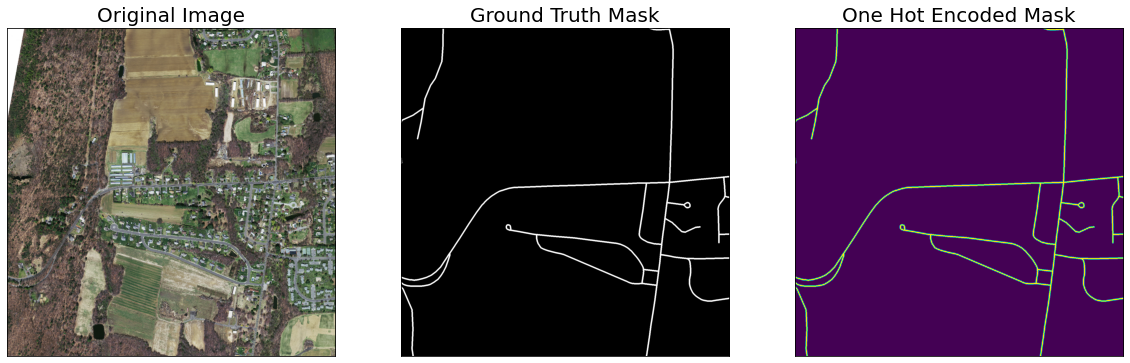

In [11]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### Defining Augmentations 

In [12]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
             p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

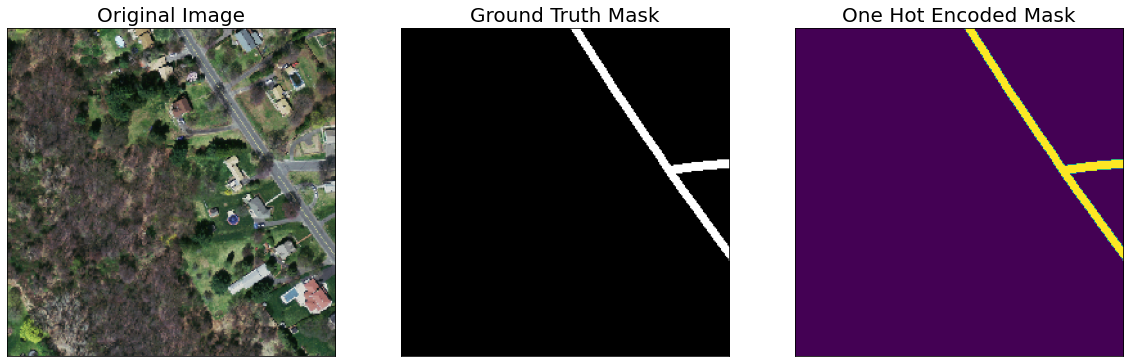

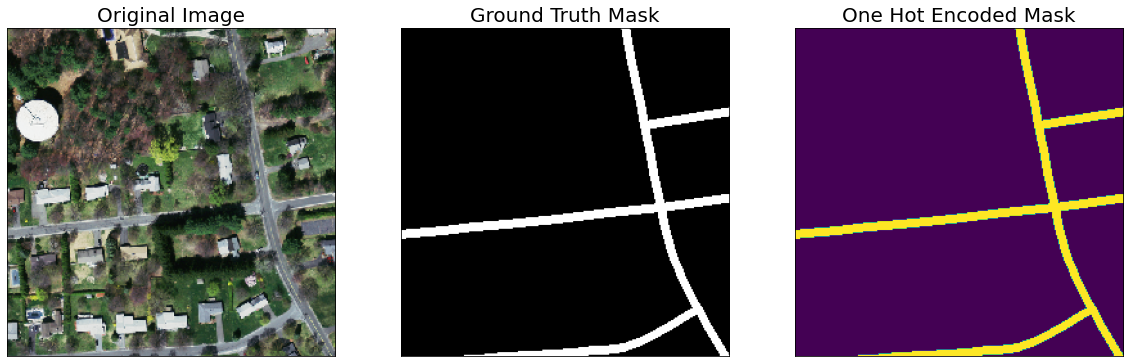

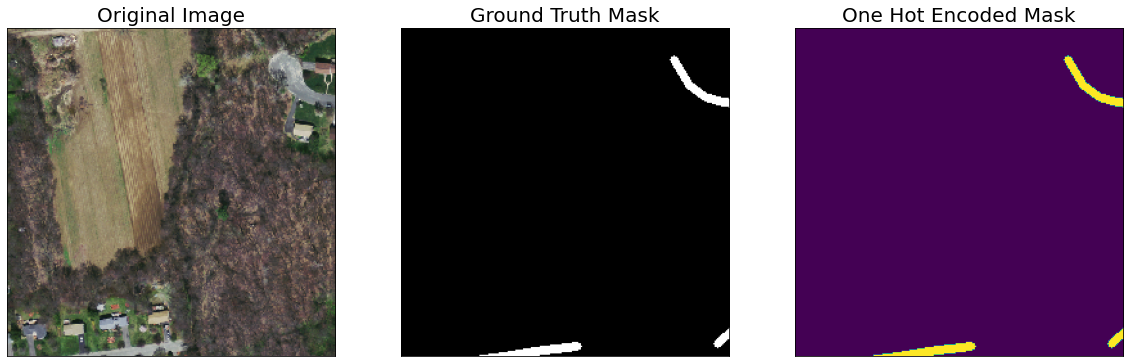

In [13]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

### Model Definition

In [14]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#### Get Train / Val DataLoaders

In [15]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [16]:
"""Various metrics based on Type I and Type II errors.

References:
    https://en.wikipedia.org/wiki/Confusion_matrix


Example:

    .. code-block:: python

        import segmentation_models_pytorch as smp

        # lets assume we have multilabel prediction for 3 classes
        output = torch.rand([10, 3, 256, 256])
        target = torch.rand([10, 3, 256, 256]).round().long()

        # first compute statistics for true positives, false positives, false negative and
        # true negative "pixels"
        tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multilabel', threshold=0.5)

        # then compute metrics with required reduction (see metric docs)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

"""
import torch
import warnings
from typing import Optional, List, Tuple, Union


__all__ = [
    "get_stats",
    "fbeta_score",
    "f1_score",
    "iou_score",
    "accuracy",
    "precision",
    "recall",
    "sensitivity",
    "specificity",
    "balanced_accuracy",
    "positive_predictive_value",
    "negative_predictive_value",
    "false_negative_rate",
    "false_positive_rate",
    "false_discovery_rate",
    "false_omission_rate",
    "positive_likelihood_ratio",
    "negative_likelihood_ratio",
]


###################################################################################################
# Statistics computation (true positives, false positives, false negatives, false positives)
###################################################################################################


def get_stats(
    output: Union[torch.LongTensor, torch.FloatTensor],
    target: torch.LongTensor,
    mode: str,
    ignore_index: Optional[int] = None,
    threshold: Optional[Union[float, List[float]]] = None,
    num_classes: Optional[int] = None,
) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor, torch.LongTensor]:
    """Compute true positive, false positive, false negative, true negative 'pixels'
    for each image and each class.

    Args:
        output (Union[torch.LongTensor, torch.FloatTensor]): Model output with following
            shapes and types depending on the specified ``mode``:

            'binary'
                shape (N, 1, ...) and ``torch.LongTensor`` or ``torch.FloatTensor``

            'multilabel'
                shape (N, C, ...) and ``torch.LongTensor`` or ``torch.FloatTensor``

            'multiclass'
                shape (N, ...) and ``torch.LongTensor``

        target (torch.LongTensor): Targets with following shapes depending on the specified ``mode``:

            'binary'
                shape (N, 1, ...)

            'multilabel'
                shape (N, C, ...)

            'multiclass'
                shape (N, ...)

        mode (str): One of ``'binary'`` | ``'multilabel'`` | ``'multiclass'``
        ignore_index (Optional[int]): Label to ignore on for metric computation.
            **Not** supproted for ``'binary'`` and ``'multilabel'`` modes.  Defaults to None.
        threshold (Optional[float, List[float]]): Binarization threshold for
            ``output`` in case of ``'binary'`` or ``'multilabel'`` modes. Defaults to None.
        num_classes (Optional[int]): Number of classes, necessary attribute
            only for ``'multiclass'`` mode. Class values should be in range 0..(num_classes - 1).
            If ``ignore_index`` is specified it should be outside the classes range, e.g. ``-1`` or
            ``255``.

    Raises:
        ValueError: in case of misconfiguration.

    Returns:
        Tuple[torch.LongTensor]: true_positive, false_positive, false_negative,
            true_negative tensors (N, C) shape each.

    """

    if torch.is_floating_point(target):
        raise ValueError(f"Target should be one of the integer types, got {target.dtype}.")

    if torch.is_floating_point(output) and threshold is None:
        raise ValueError(
            f"Output should be one of the integer types if ``threshold`` is not None, got {output.dtype}."
        )

    if torch.is_floating_point(output) and mode == "multiclass":
        raise ValueError(f"For ``multiclass`` mode ``output`` should be one of the integer types, got {output.dtype}.")

    if mode not in {"binary", "multiclass", "multilabel"}:
        raise ValueError(f"``mode`` should be in ['binary', 'multiclass', 'multilabel'], got mode={mode}.")

    if mode == "multiclass" and threshold is not None:
        raise ValueError("``threshold`` parameter does not supported for this 'multiclass' mode")

    if output.shape != target.shape:
        raise ValueError(
            "Dimensions should match, but ``output`` shape is not equal to ``target`` "
            + f"shape, {output.shape} != {target.shape}"
        )

    if mode != "multiclass" and ignore_index is not None:
        raise ValueError(f"``ignore_index`` parameter is not supproted for '{mode}' mode")

    if mode == "multiclass" and num_classes is None:
        raise ValueError("``num_classes`` attribute should be not ``None`` for 'multiclass' mode.")

    if ignore_index is not None and 0 <= ignore_index <= num_classes - 1:
        raise ValueError(
            f"``ignore_index`` should be outside the class values range, but got class values in range "
            f"0..{num_classes - 1} and ``ignore_index={ignore_index}``. Hint: if you have ``ignore_index = 0``"
            f"consirder subtracting ``1`` from your target and model output to make ``ignore_index = -1``"
            f"and relevant class values started from ``0``."
        )

    if mode == "multiclass":
        tp, fp, fn, tn = _get_stats_multiclass(output, target, num_classes, ignore_index)
    else:
        if threshold is not None:
            output = torch.where(output >= threshold, 1, 0)
            target = torch.where(target >= threshold, 1, 0)
        tp, fp, fn, tn = _get_stats_multilabel(output, target)

    return tp, fp, fn, tn


@torch.no_grad()
def _get_stats_multiclass(
    output: torch.LongTensor,
    target: torch.LongTensor,
    num_classes: int,
    ignore_index: Optional[int],
) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor, torch.LongTensor]:

    batch_size, *dims = output.shape
    num_elements = torch.prod(torch.tensor(dims)).long()

    if ignore_index is not None:
        ignore = target == ignore_index
        output = torch.where(ignore, -1, output)
        target = torch.where(ignore, -1, target)
        ignore_per_sample = ignore.view(batch_size, -1).sum(1)

    tp_count = torch.zeros(batch_size, num_classes, dtype=torch.long)
    fp_count = torch.zeros(batch_size, num_classes, dtype=torch.long)
    fn_count = torch.zeros(batch_size, num_classes, dtype=torch.long)
    tn_count = torch.zeros(batch_size, num_classes, dtype=torch.long)

    for i in range(batch_size):
        target_i = target[i]
        output_i = output[i]
        mask = output_i == target_i
        matched = torch.where(mask, target_i, -1)
        tp = torch.histc(matched.float(), bins=num_classes, min=0, max=num_classes - 1)
        fp = torch.histc(output_i.float(), bins=num_classes, min=0, max=num_classes - 1) - tp
        fn = torch.histc(target_i.float(), bins=num_classes, min=0, max=num_classes - 1) - tp
        tn = num_elements - tp - fp - fn
        if ignore_index is not None:
            tn = tn - ignore_per_sample[i]
        tp_count[i] = tp.long()
        fp_count[i] = fp.long()
        fn_count[i] = fn.long()
        tn_count[i] = tn.long()

    return tp_count, fp_count, fn_count, tn_count


@torch.no_grad()
def _get_stats_multilabel(
    output: torch.LongTensor,
    target: torch.LongTensor,
) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor, torch.LongTensor]:

    batch_size, num_classes, *dims = target.shape
    output = output.view(batch_size, num_classes, -1)
    target = target.view(batch_size, num_classes, -1)

    tp = (output * target).sum(2)
    fp = output.sum(2) - tp
    fn = target.sum(2) - tp
    tn = torch.prod(torch.tensor(dims)) - (tp + fp + fn)

    return tp, fp, fn, tn


###################################################################################################
# Metrics computation
###################################################################################################


def _handle_zero_division(x, zero_division):
    nans = torch.isnan(x)
    if torch.any(nans) and zero_division == "warn":
        warnings.warn("Zero division in metric calculation!")
    value = zero_division if zero_division != "warn" else 0
    value = torch.tensor(value, dtype=x.dtype).to(x.device)
    x = torch.where(nans, value, x)
    return x


def _compute_metric(
    metric_fn,
    tp,
    fp,
    fn,
    tn,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division="warn",
    **metric_kwargs,
) -> float:

    if class_weights is None and reduction is not None and "weighted" in reduction:
        raise ValueError(f"Class weights should be provided for `{reduction}` reduction")

    class_weights = class_weights if class_weights is not None else 1.0
    class_weights = torch.tensor(class_weights).to(tp.device)
    class_weights = class_weights / class_weights.sum()

    if reduction == "micro":
        tp = tp.sum()
        fp = fp.sum()
        fn = fn.sum()
        tn = tn.sum()
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)

    elif reduction == "macro":
        tp = tp.sum(0)
        fp = fp.sum(0)
        fn = fn.sum(0)
        tn = tn.sum(0)
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)
        score = _handle_zero_division(score, zero_division)
        score = (score * class_weights).mean()

    elif reduction == "weighted":
        tp = tp.sum(0)
        fp = fp.sum(0)
        fn = fn.sum(0)
        tn = tn.sum(0)
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)
        score = _handle_zero_division(score, zero_division)
        score = (score * class_weights).sum()

    elif reduction == "micro-imagewise":
        tp = tp.sum(1)
        fp = fp.sum(1)
        fn = fn.sum(1)
        tn = tn.sum(1)
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)
        score = _handle_zero_division(score, zero_division)
        score = score.mean()

    elif reduction == "macro-imagewise" or reduction == "weighted-imagewise":
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)
        score = _handle_zero_division(score, zero_division)
        score = (score.mean(0) * class_weights).mean()

    elif reduction == "none" or reduction is None:
        score = metric_fn(tp, fp, fn, tn, **metric_kwargs)
        score = _handle_zero_division(score, zero_division)

    else:
        raise ValueError(
            "`reduction` should be in [micro, macro, weighted, micro-imagewise,"
            + "macro-imagesize, weighted-imagewise, none, None]"
        )

    return score


# Logic for metric computation, all metrics are with the same interface


def _fbeta_score(tp, fp, fn, tn, beta=1):
    beta_tp = (1 + beta**2) * tp
    beta_fn = (beta**2) * fn
    score = beta_tp / (beta_tp + beta_fn + fp)
    return score


def _iou_score(tp, fp, fn, tn):
    return tp / (tp + fp + fn)


def _accuracy(tp, fp, fn, tn):
    return (tp + tn) / (tp + fp + fn + tn)


def _sensitivity(tp, fp, fn, tn):
    return tp / (tp + fn)


def _specificity(tp, fp, fn, tn):
    return tn / (tn + fp)


def _balanced_accuracy(tp, fp, fn, tn):
    return (_sensitivity(tp, fp, fn, tn) + _specificity(tp, fp, fn, tn)) / 2


def _positive_predictive_value(tp, fp, fn, tn):
    return tp / (tp + fp)


def _negative_predictive_value(tp, fp, fn, tn):
    return tn / (tn + fn)


def _false_negative_rate(tp, fp, fn, tn):
    return fn / (fn + tp)


def _false_positive_rate(tp, fp, fn, tn):
    return fp / (fp + tn)


def _false_discovery_rate(tp, fp, fn, tn):
    return 1 - _positive_predictive_value(tp, fp, fn, tn)


def _false_omission_rate(tp, fp, fn, tn):
    return 1 - _negative_predictive_value(tp, fp, fn, tn)


def _positive_likelihood_ratio(tp, fp, fn, tn):
    return _sensitivity(tp, fp, fn, tn) / _false_positive_rate(tp, fp, fn, tn)


def _negative_likelihood_ratio(tp, fp, fn, tn):
    return _false_negative_rate(tp, fp, fn, tn) / _specificity(tp, fp, fn, tn)


def fbeta_score(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    beta: float = 1.0,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """F beta score"""
    return _compute_metric(
        _fbeta_score,
        tp,
        fp,
        fn,
        tn,
        beta=beta,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def f1_score(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """F1 score"""
    return _compute_metric(
        _fbeta_score,
        tp,
        fp,
        fn,
        tn,
        beta=1.0,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def iou_score(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """IoU score or Jaccard index"""  # noqa
    return _compute_metric(
        _iou_score,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def accuracy(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Accuracy"""
    return _compute_metric(
        _accuracy,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def sensitivity(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Sensitivity, recall, hit rate, or true positive rate (TPR)"""
    return _compute_metric(
        _sensitivity,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def specificity(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Specificity, selectivity or true negative rate (TNR)"""
    return _compute_metric(
        _specificity,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def balanced_accuracy(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Balanced accuracy"""
    return _compute_metric(
        _balanced_accuracy,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def positive_predictive_value(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Precision or positive predictive value (PPV)"""
    return _compute_metric(
        _positive_predictive_value,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def negative_predictive_value(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Negative predictive value (NPV)"""
    return _compute_metric(
        _negative_predictive_value,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def false_negative_rate(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Miss rate or false negative rate (FNR)"""
    return _compute_metric(
        _false_negative_rate,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def false_positive_rate(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Fall-out or false positive rate (FPR)"""
    return _compute_metric(
        _false_positive_rate,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def false_discovery_rate(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """False discovery rate (FDR)"""  # noqa
    return _compute_metric(
        _false_discovery_rate,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def false_omission_rate(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """False omission rate (FOR)"""  # noqa
    return _compute_metric(
        _false_omission_rate,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def positive_likelihood_ratio(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Positive likelihood ratio (LR+)"""
    return _compute_metric(
        _positive_likelihood_ratio,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


def negative_likelihood_ratio(
    tp: torch.LongTensor,
    fp: torch.LongTensor,
    fn: torch.LongTensor,
    tn: torch.LongTensor,
    reduction: Optional[str] = None,
    class_weights: Optional[List[float]] = None,
    zero_division: Union[str, float] = 1.0,
) -> torch.Tensor:
    """Negative likelihood ratio (LR-)"""
    return _compute_metric(
        _negative_likelihood_ratio,
        tp,
        fp,
        fn,
        tn,
        reduction=reduction,
        class_weights=class_weights,
        zero_division=zero_division,
    )


_doc = """

    Args:
        tp (torch.LongTensor): tensor of shape (N, C), true positive cases
        fp (torch.LongTensor): tensor of shape (N, C), false positive cases
        fn (torch.LongTensor): tensor of shape (N, C), false negative cases
        tn (torch.LongTensor): tensor of shape (N, C), true negative cases
        reduction (Optional[str]): Define how to aggregate metric between classes and images:

            - 'micro'
                Sum true positive, false positive, false negative and true negative pixels over
                all images and all classes and then compute score.

            - 'macro'
                Sum true positive, false positive, false negative and true negative pixels over
                all images for each label, then compute score for each label separately and average labels scores.
                This does not take label imbalance into account.

            - 'weighted'
                Sum true positive, false positive, false negative and true negative pixels over
                all images for each label, then compute score for each label separately and average
                weighted labels scores.

            - 'micro-imagewise'
                Sum true positive, false positive, false negative and true negative pixels for **each image**,
                then compute score for **each image** and average scores over dataset. All images contribute equally
                to final score, however takes into accout class imbalance for each image.

            - 'macro-imagewise'
                Compute score for each image and for each class on that image separately, then compute average score
                on each image over labels and average image scores over dataset. Does not take into account label
                imbalance on each image.

            - 'weighted-imagewise'
                Compute score for each image and for each class on that image separately, then compute weighted average
                score on each image over labels and average image scores over dataset.

            - 'none' or ``None``
                Same as ``'macro-imagewise'``, but without any reduction.

            For ``'binary'`` case ``'micro' = 'macro' = 'weighted'`` and
            ``'micro-imagewise' = 'macro-imagewise' = 'weighted-imagewise'``.

            Prefixes ``'micro'``, ``'macro'`` and ``'weighted'`` define how the scores for classes will be aggregated,
            while postfix ``'imagewise'`` defines how scores between the images will be aggregated.

        class_weights (Optional[List[float]]): list of class weights for metric
            aggregation, in case of `weighted*` reduction is chosen. Defaults to None.
        zero_division (Union[str, float]): Sets the value to return when there is a zero division,
            i.e. when all predictions and labels are negative. If set to “warn”, this acts as 0,
            but warnings are also raised. Defaults to 1.

    Returns:
        torch.Tensor: if ``'reduction'`` is not ``None`` or ``'none'`` returns scalar metric,
            else returns tensor of shape (N, C)

    References:
        https://en.wikipedia.org/wiki/Confusion_matrix
"""

fbeta_score.__doc__ += _doc
f1_score.__doc__ += _doc
iou_score.__doc__ += _doc
accuracy.__doc__ += _doc
sensitivity.__doc__ += _doc
specificity.__doc__ += _doc
balanced_accuracy.__doc__ += _doc
positive_predictive_value.__doc__ += _doc
negative_predictive_value.__doc__ += _doc
false_negative_rate.__doc__ += _doc
false_positive_rate.__doc__ += _doc
false_discovery_rate.__doc__ += _doc
false_omission_rate.__doc__ += _doc
positive_likelihood_ratio.__doc__ += _doc
negative_likelihood_ratio.__doc__ += _doc

precision = positive_predictive_value
recall = sensitivity

In [17]:
import segmentation_models_pytorch.utils.metrics

#### Set Hyperparams

In [18]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 100


# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('/content/drive/MyDrive/trained-model/best_model.pth'):
    model = torch.load('/content/drive/MyDrive/trained-model/best_model.pth', map_location=DEVICE)

In [19]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training UNet

In [ ]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, '/content/drive/MyDrive/trained-model/best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 14/14 [03:50<00:00, 16.49s/it, dice_loss - 0.1135, iou_score - 0.8767]
Model saved!

Epoch: 1
valid: 100%|██████████| 14/14 [03:48<00:00, 16.34s/it, dice_loss - 0.1131, iou_score - 0.8772]
Model saved!

Epoch: 2
train:  50%|█████     | 35/70 [16:22<15:45, 27.01s/it, dice_loss - 0.08346, iou_score - 0.9374]

### Prediction on Test Data

In [21]:
# load best saved model checkpoint from the current run
if os.path.exists('/content/drive/MyDrive/trained-model/best_model.pth/best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('/content/drive/MyDrive/trained-model/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

In [22]:
best_model 

NameError: ignored

In [ ]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [ ]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_road_heatmap = pred_road_heatmap
    )

### Model Evaluation on Test Dataset

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

### Plot Dice Loss & IoU Metric for Train vs. Val

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)

plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()